In [2]:
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import time
import itertools
import statsmodels.api as sm
import numpy.ma as ma
from scipy.stats.stats import pearsonr, normaltest
from scipy.spatial.distance import correlation
from sklearn.model_selection import train_test_split
os.getcwd()
os.chdir(r'C:\Users\Haneef Usmani\Desktop\STAT 303-2\Project')

In [5]:
flight = pd.read_csv('flights_clean.csv').dropna().sample(10000)

In [6]:
# split flight into train and test
train, test = train_test_split(flight, test_size=0.2)
# drop all categorical variables from train
train_drop = train.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)
X = train[['airline', 'day', 'day_of_week', 'destination_airport', 'destination_latitude', 'destination_longitude', 'distance', 'month', 'origin_airport', 'origin_latitude', 'origin_longitude', 'scheduled_arrival', 'scheduled_departure', 'scheduled_time', 'state_destination', 'state_origin', 'taxi_in', 'taxi_out', 'day_of_year', 'origin_temperature', 'destination_temperature']]
# take out all categorical variables
X = X.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)

In [7]:
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = smf.ols('(departure_delay)~' + '+'.join(predictor_subset),data = train_drop).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [8]:
def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [9]:
models_best = backward_selection()

Processed  16 models on 15 predictors in 0.2918362617492676 seconds.
Processed  15 models on 14 predictors in 0.26543593406677246 seconds.
Processed  14 models on 13 predictors in 0.23280715942382812 seconds.
Processed  13 models on 12 predictors in 0.19021105766296387 seconds.
Processed  12 models on 11 predictors in 0.15801167488098145 seconds.
Processed  11 models on 10 predictors in 0.13372373580932617 seconds.
Processed  10 models on 9 predictors in 0.11087369918823242 seconds.
Processed  9 models on 8 predictors in 0.09299659729003906 seconds.
Processed  8 models on 7 predictors in 0.07613754272460938 seconds.
Processed  7 models on 6 predictors in 0.059465646743774414 seconds.
Processed  6 models on 5 predictors in 0.04106855392456055 seconds.
Processed  5 models on 4 predictors in 0.032152652740478516 seconds.
Processed  4 models on 3 predictors in 0.022205352783203125 seconds.
Processed  3 models on 2 predictors in 0.012955188751220703 seconds.
Processed  2 models on 1 predict

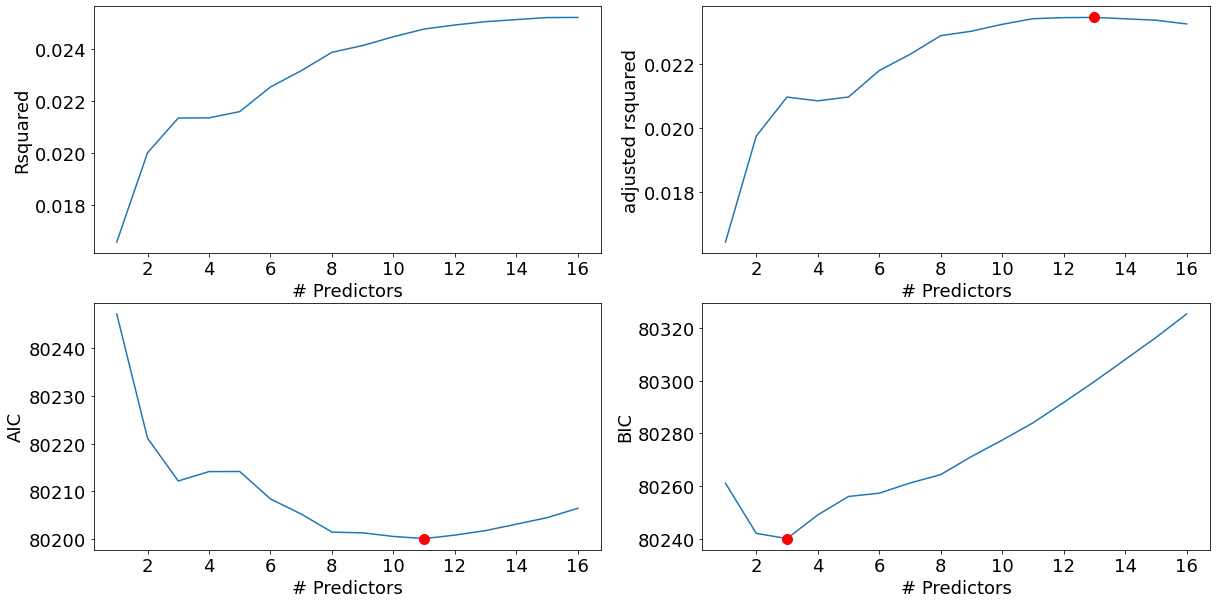

In [11]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [14]:
best_fwd_reg_model = models_best['model'][3]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        departure_delay   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     58.12
Date:                Thu, 02 Mar 2023   Prob (F-statistic):           3.66e-37
Time:                        16:55:42   Log-Likelihood:                -40102.
No. Observations:                8000   AIC:                         8.021e+04
Df Residuals:                    7996   BIC:                         8.024e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -8.3254      1.506     -5.528      0.000     -11.278      -5.373
scheduled_arrival       0.0058      0.002      3.311      0.001       0.002       0.009
scheduled_departure     0.0121      0.002      6.509      0.000       0.008       0.016
taxi_out                0.2300      0.044      5.240      0.000       0.144       0.316
==============================================================================
Omnibus:                     9127.122   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1197381.132
Skew:                           5.846   Prob(JB):                         0.00
Kurtosis:                      61.783   Cond. No.                     4.72e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
pred_price = (best_fwd_reg_model.predict(test))
np.sqrt(((pred_price - test.departure_delay)**2).mean())

35.00798180838737